# Lecture 15 - Benders Decomposition

## Header

In [1]:
# # Dependencies: Uncomment and run this cell if you don't have these packages 
# using Pkg
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Plots")

In [2]:
include("src/data.jl");
include("src/opt.jl");
include("src/out.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-18


## Data Input

We'll look at two medium-sized instances with 50 and 100 facilities.

In [3]:
n_facilities = 50
fixed_cost = 10
dat = FacilityInstance(n_facilities*10, n_facilities, fixed_cost);
dat_big = FacilityInstance(n_facilities*20, n_facilities*2, fixed_cost);

Plot the smaller instance.

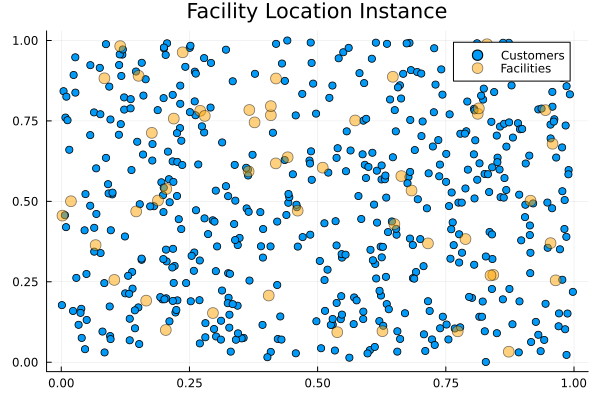

In [4]:
plot_instance(dat)

## Benders Decomposition

First, we'll try fully solving the master problem at every iteration. We can see that the running times increase as we add cuts. This can be a problem if we need to add a large number of cuts.

In [5]:
mp = MasterProblem(dat)
n_added = generate_cut!(mp)
n_iterations = 0
while n_added > 0 && n_iterations <= 100
    # Print timing every few iterations
    if n_iterations % 10 == 0
        @time JuMP.optimize!(mp.model)
    else
        JuMP.optimize!(mp.model)
    end
    global n_added = generate_cut!(mp)
    global n_iterations += 1
end

  0.008044 seconds (200 allocations: 7.141 KiB, 43.80% compilation time)
  0.106229 seconds (5.19 k allocations: 162.109 KiB)
  0.122421 seconds (7.55 k allocations: 235.828 KiB)
  0.133372 seconds (4.91 k allocations: 153.422 KiB)
  0.123499 seconds (5.57 k allocations: 174.203 KiB)
  0.167748 seconds (6.20 k allocations: 193.734 KiB)
  0.209677 seconds (9.39 k allocations: 293.359 KiB)
  0.226579 seconds (10.93 k allocations: 341.547 KiB)
  0.268083 seconds (10.35 k allocations: 323.578 KiB)
  0.278974 seconds (13.17 k allocations: 411.578 KiB)
  0.299463 seconds (14.11 k allocations: 440.922 KiB)


Now we'll try the "modern" implementation of Benders decomposition, which lazily adds cuts in the branch-and-bound tree. It's much faster!

In [6]:
mp_call = MasterProblem(dat)
add_benders_callback!(mp_call)
solution_call = solve!(mp_call)

Set parameter OutputFlag to value 1
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1 rows, 51 columns and 50 nonzeros
Model fingerprint: 0xa9bf3b26
Variable types: 1 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 51 columns, 50 nonzeros
Variable types: 1 continuous, 50 integer (50 binary)

Root relaxation: objective 2.150934e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.50934    0    1          -   21.50934      -     -    0s
H  

Facility Solution with cost 136.69

We can plot the solution.

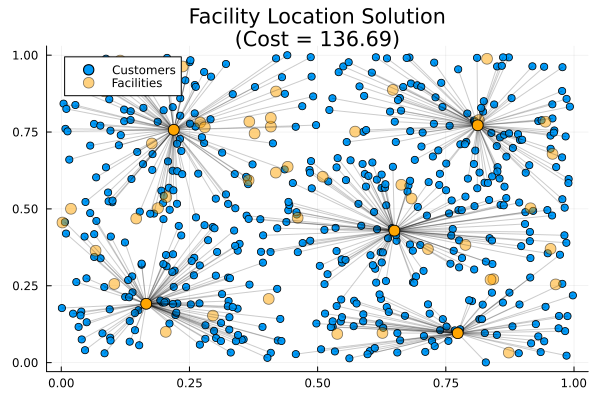

In [7]:
plot_solution(solution_call)

## Comparison against full model

Let's see how long it takes to run the full model.

In [8]:
mdl = FacilityModel(dat)
solution = solve!(mdl)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 25500 rows, 25050 columns and 75000 nonzeros
Model fingerprint: 0xd7275d31
Variable types: 25000 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 752.7028315
Presolve time: 0.04s
Presolved: 25500 rows, 25050 columns, 75000 nonzeros
Variable types: 25000 continuous, 50 integer (50 binary)

Root relaxation: objective 1.366885e+02, 4801 iterations, 0.03 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     136.6885486  136.68855  0.00%     -    0s



Facility Solution with cost 136.69

The good news is that the objective value matches what we got from Benders, so we seem to have implemented Benders correctly. The bad news is that Benders is much slower! Why?

## Benders can be slow to converge

Let's see how Benders does on the bigger instance.

In [9]:
mp_call_big = MasterProblem(dat_big)
JuMP.set_time_limit_sec(mp_call_big.model, 120.0)
add_benders_callback!(mp_call_big)
solution_call = solve!(mp_call_big)

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1 rows, 101 columns and 100 nonzeros
Model fingerprint: 0xc61d44c8
Variable types: 1 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 101 columns, 100 nonzeros
Variable types: 1 continuous, 100 integer (100 binary)

Root relaxation: objective 2.136947e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.36947    0    1

┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/D44Aq/src/operators.jl:279


Facility Solution with cost 220.68